# Supervised Machine Learning Project 
## Asset Maintenance use-case for a Synthetic Railway Company
#### 27.04.2022

</br>


### Data Set Information:

- Asset dataset - This is data that describes the asset
- Asset repairs - This details the repairs of assets
- Asset replacements - This is a list of times when assets have been replaced (failed)
- Planned maintenance - This describes if the reapir or replacement 
- Additional asset attributes - This gives additional infomation about assets

### References:
- [1] https://towardsdatascience.com/how-to-implement-machine-learning-for-predictive-maintenance-4633cdbe4860
- [2] https://medium.com/swlh/machine-learning-for-equipment-failure-prediction-and-predictive-maintenance-pm-e72b1ce42da1
- [3] https://www.infoq.com/articles/machine-learning-techniques-predictive-maintenance/
- [4] Introduction to Machine Learning with Python A Guide for Data Scientists by Andreas C. Müller, Sarah Guido (book)

In [270]:
# importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [271]:
# dataset files location
folder_path = './SyntheticData/'

In [272]:
# get all files
files = os.listdir(folder_path)
print(files)

# organize all files in a dictionary of dataframes
df_dict = {}
filenames = []
for file in files: 
    filenames.append(file[:-4])  # slice .csv extension from name
    df_dict[file[:-4]] = pd.read_csv(folder_path + file)    

['asset_attribute_data_general.csv', 'asset_attribute_data_usage.csv', 'asset_attribute_data_weather.csv', 'asset_data.csv', 'planned_data.csv', 'repair_data.csv', 'replacement_data.csv']


## 1. Getting familiar with the data

In [273]:
df_dict['asset_attribute_data_general'].head()

,asset_id,asset_install_team,asset_line,asset_material
0,A:cpjwvv,team4,east_line,iron
1,A:xoauw0,team3,south_line,steel
2,A:xpqps2,team1,east_line,iron
3,A:m44bmt,team4,west_line,steel
4,A:rwkyh1,team2,north_line,steel


In [274]:
df_dict['asset_attribute_data_usage'].head()

,asset_id,asset_trains_per_hour
0,A:cpjwvv,2.0
1,A:xoauw0,4.0
2,A:xpqps2,4.0
3,A:m44bmt,4.0
4,A:rwkyh1,1.0


In [275]:
df_dict['asset_attribute_data_weather'].head()

,asset_id,asset_weather_cluster
0,A:cpjwvv,standard
1,A:xoauw0,standard
2,A:xpqps2,sun
3,A:m44bmt,sun
4,A:rwkyh1,standard


In [276]:
df_dict['asset_data'].head()

,asset_id,end_date,latitude,longitude,previous_repairs,previous_unplanned,start_date
0,A:cpjwvv,2012-02-26,51.108966,-1.382032,0,0,2008-06-26
1,A:xoauw0,2005-03-01,58.369692,-4.982743,0,0,2003-06-08
2,A:xpqps2,2009-10-27,55.759249,-4.593591,0,0,2007-03-03
3,A:m44bmt,2008-02-23,52.289685,-1.418834,0,0,2007-01-17
4,A:rwkyh1,2013-06-21,55.686979,-4.542553,0,0,2012-06-03


The previous/above tables all share an identification column that could be used to merge them: <b> asset_id </b>

In [277]:
df_dict['planned_data'].head()

,asset_id,event_date,event_id,planned
0,A:cpjwvv,2011-05-06,E:6avbyn53sz,False
1,A:cpjwvv,2008-08-30,E:trj6ixh0o9,False
2,A:cpjwvv,2009-02-06,E:y5bjtvl55l,False
3,A:cpjwvv,2010-02-07,E:evsbi3vj21,False
4,A:cpjwvv,2010-02-17,E:njcddphr3b,False


In [278]:
df_dict['repair_data'].head()

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned
0,A:cpjwvv,2011-05-06,E:6avbyn53sz,2011-03-25,1,1
1,A:xoauw0,2004-05-10,E:8h4dpsljy3,2003-08-28,1,1
2,A:xoauw0,2004-10-18,E:zl0sp2rps7,2004-05-10,2,2
3,A:xpqps2,2009-09-07,E:ndxhmxamfi,2007-10-03,1,1
4,A:m44bmt,2007-03-29,E:01zkvga68v,2007-03-26,1,1


In [279]:
df_dict['replacement_data'].head()

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned
0,A:cpjwvv,2008-08-30,E:trj6ixh0o9,2008-06-26,0,0
1,A:cpjwvv,2009-02-06,E:y5bjtvl55l,2008-08-30,0,0
2,A:cpjwvv,2010-02-07,E:evsbi3vj21,2009-02-06,0,0
3,A:cpjwvv,2010-02-17,E:njcddphr3b,2010-02-07,0,0
4,A:cpjwvv,2010-05-18,E:fry99yixfk,2010-02-17,0,0


The previous/above tables all share columns <b> asset_id </b> and <b> event_id </b> that are going be used to merge them

In [280]:
# Check datasets size
for name in filenames:
    print(name, df_dict[name].shape)

asset_attribute_data_general (200, 4)
asset_attribute_data_usage (200, 2)
asset_attribute_data_weather (200, 2)
asset_data (200, 7)
planned_data (2032, 4)
repair_data (859, 6)
replacement_data (1173, 6)


* More repairs than replacements, means unbalanced data regarding type of event
* For the purpose of the assignment going to assume replacements and repairs as events in general
* 200 assets, 2032 events, distributed by repairs and replacements (859+1173=2032)

## 2. Building feature datasets 
Merging and droping

#### Assets feature dataset - Merging assets data according to asset_id

In [281]:
df_assets_or = pd.merge(df_dict['asset_attribute_data_general'], df_dict['asset_attribute_data_usage'], on='asset_id')
df_assets_or = pd.merge(df_assets_or, df_dict['asset_attribute_data_weather'], on='asset_id')

In [282]:
df_assets_or

,asset_id,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster
0,A:cpjwvv,team4,east_line,iron,2.0,standard
1,A:xoauw0,team3,south_line,steel,4.0,standard
2,A:xpqps2,team1,east_line,iron,4.0,sun
3,A:m44bmt,team4,west_line,steel,4.0,sun
4,A:rwkyh1,team2,north_line,steel,1.0,standard
...,...,...,...,...,...,...
195,A:271d3q,team4,south_line,iron,4.0,standard
196,A:6tjk91,team3,west_line,iron,4.0,standard
197,A:j9z5oa,team2,east_line,iron,8.0,heavy_rain
198,A:100egl,team2,west_line,alloy,2.0,sun


In [283]:
df_assets_or = pd.merge(df_assets_or, df_dict['asset_data'], on='asset_id')

In [284]:
df_assets_or

,asset_id,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,end_date,latitude,longitude,previous_repairs,previous_unplanned,start_date
0,A:cpjwvv,team4,east_line,iron,2.0,standard,2012-02-26,51.108966,-1.382032,0,0,2008-06-26
1,A:xoauw0,team3,south_line,steel,4.0,standard,2005-03-01,58.369692,-4.982743,0,0,2003-06-08
2,A:xpqps2,team1,east_line,iron,4.0,sun,2009-10-27,55.759249,-4.593591,0,0,2007-03-03
3,A:m44bmt,team4,west_line,steel,4.0,sun,2008-02-23,52.289685,-1.418834,0,0,2007-01-17
4,A:rwkyh1,team2,north_line,steel,1.0,standard,2013-06-21,55.686979,-4.542553,0,0,2012-06-03
...,...,...,...,...,...,...,...,...,...,...,...,...
195,A:271d3q,team4,south_line,iron,4.0,standard,2012-05-12,52.883360,-2.048643,0,0,2005-10-15
196,A:6tjk91,team3,west_line,iron,4.0,standard,2016-07-08,54.765397,-2.104487,0,0,2013-08-22
197,A:j9z5oa,team2,east_line,iron,8.0,heavy_rain,2017-06-01,54.332715,-2.370033,0,0,2013-05-21
198,A:100egl,team2,west_line,alloy,2.0,sun,2013-08-18,54.151059,-2.068212,0,0,2008-05-04


In [285]:
# keep original dataframe df_assets_or unchanged, might be useful in the future
df_assets = df_assets_or
# Remove latitude and longitude features. Realy hard to work with coordinates.
df_assets = df_assets.drop(['latitude', 'longitude'], axis=1)

In [286]:
# Remove this features to simplify our dataset and also didnt quite understood whats the logic behind these two features.
# In a professional scenario this features would need to be discussed to get more insight and assess their importance 
# to the business and goal of the project
df_assets = df_assets.drop(['previous_repairs', 'previous_unplanned'], axis=1)

In [287]:
# Just organizing the columns
def move_col(name, pos):
    column = df_assets.pop(name)
    df_assets.insert(pos, name, column)
    
move_col('start_date', 1)
move_col('end_date', 2)

Going to create new feature: <b> life_time </b>, represents days between the start and end dates of the asset

In [288]:
# convert dates to datetime
df_assets['start_date'] = pd.to_datetime(df_assets['start_date'], format='%Y-%m-%d', errors='ignore')
df_assets['end_date'] = pd.to_datetime(df_assets['end_date'], format='%Y-%m-%d', errors='ignore')

# new life time variable with the total working days of the asset
df_assets['life_time'] = (df_assets['end_date'] - df_assets['start_date']).dt.days

# drop uncessary columns
df_assets = df_assets.drop(['start_date', 'end_date'], axis=1)

In [289]:
df_assets

,asset_id,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,life_time
0,A:cpjwvv,team4,east_line,iron,2.0,standard,1340
1,A:xoauw0,team3,south_line,steel,4.0,standard,632
2,A:xpqps2,team1,east_line,iron,4.0,sun,969
3,A:m44bmt,team4,west_line,steel,4.0,sun,402
4,A:rwkyh1,team2,north_line,steel,1.0,standard,383
...,...,...,...,...,...,...,...
195,A:271d3q,team4,south_line,iron,4.0,standard,2401
196,A:6tjk91,team3,west_line,iron,4.0,standard,1051
197,A:j9z5oa,team2,east_line,iron,8.0,heavy_rain,1472
198,A:100egl,team2,west_line,alloy,2.0,sun,1932


#### Repairs/Replacements feature dataset - Merging events data according to events_id and assets_id

In [290]:
df_repairs_or = pd.merge(
    df_dict['repair_data'], 
    df_dict['replacement_data'], 
    on=['asset_id', 'event_id', 'event_date', 'installed_date', 'previous_repairs', 'previous_unplanned'], 
    how='outer')

In [291]:
df_repairs_or

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned
0,A:cpjwvv,2011-05-06,E:6avbyn53sz,2011-03-25,1,1
1,A:xoauw0,2004-05-10,E:8h4dpsljy3,2003-08-28,1,1
2,A:xoauw0,2004-10-18,E:zl0sp2rps7,2004-05-10,2,2
3,A:xpqps2,2009-09-07,E:ndxhmxamfi,2007-10-03,1,1
4,A:m44bmt,2007-03-29,E:01zkvga68v,2007-03-26,1,1
...,...,...,...,...,...,...
2027,A:bo36ea,2008-03-11,E:tiimfa24q1,2007-12-13,0,0
2028,A:bo36ea,2008-06-08,E:o7x8b82wrs,2008-05-26,0,0
2029,A:bo36ea,2008-06-08,E:urquo998rq,2008-06-08,0,0
2030,A:bo36ea,2008-12-12,E:cxh6sozhrx,2008-06-08,0,0


In [292]:
df_repairs_or = pd.merge(
    df_repairs_or, 
    df_dict['planned_data'], 
    on=['asset_id', 'event_id', 'event_date'])

In [293]:
df_repairs_or

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned,planned
0,A:cpjwvv,2011-05-06,E:6avbyn53sz,2011-03-25,1,1,False
1,A:xoauw0,2004-05-10,E:8h4dpsljy3,2003-08-28,1,1,False
2,A:xoauw0,2004-10-18,E:zl0sp2rps7,2004-05-10,2,2,False
3,A:xpqps2,2009-09-07,E:ndxhmxamfi,2007-10-03,1,1,False
4,A:m44bmt,2007-03-29,E:01zkvga68v,2007-03-26,1,1,False
...,...,...,...,...,...,...,...
2027,A:bo36ea,2008-03-11,E:tiimfa24q1,2007-12-13,0,0,False
2028,A:bo36ea,2008-06-08,E:o7x8b82wrs,2008-05-26,0,0,False
2029,A:bo36ea,2008-06-08,E:urquo998rq,2008-06-08,0,0,True
2030,A:bo36ea,2008-12-12,E:cxh6sozhrx,2008-06-08,0,0,False


In [294]:
# keep original dataframe df_repairs_or unchanged
df_repairs = df_repairs_or
# set date vars to datetime type
df_repairs['event_date'] = pd.to_datetime(df_repairs['event_date'], format='%Y-%m-%d', errors='ignore')
df_repairs['installed_date'] = pd.to_datetime(df_repairs['installed_date'], format='%Y-%m-%d', errors='ignore')

Going to create new feature: <b> RUL </b> (Remaining useful life), represents days between next asset event and in our dataset its the difference between installed_date and event_date

In [295]:
df_repairs['RUL'] = (df_repairs['event_date'] - df_repairs['installed_date']).dt.days
# remove features that are not going to be used
df_repairs = df_repairs.drop(['event_id', 'previous_repairs', 'previous_unplanned', 'planned'], axis=1)
# order by dates
df_repairs = df_repairs.sort_values(by='installed_date')

In [296]:
df_repairs

,asset_id,event_date,installed_date,RUL
327,A:hhuqjc,2000-03-02,2000-01-06,56
496,A:g387mk,2000-05-07,2000-01-27,101
1018,A:u65cz7,2000-02-26,2000-02-15,11
725,A:5j07tf,2001-10-07,2000-02-17,598
1019,A:u65cz7,2000-08-11,2000-02-26,167
...,...,...,...,...
1473,A:ii3vcg,2017-05-01,2017-02-27,63
1931,A:tzbon5,2017-05-11,2017-03-04,68
1972,A:4f0kgt,2017-04-02,2017-03-27,6
666,A:9ks73c,2017-05-02,2017-04-05,27


#### Comparing and analysing assets info with repairements/replacements

In [297]:
df_repairs.loc[df_repairs['asset_id'] == 'A:cpjwvv', :]

,asset_id,event_date,installed_date,RUL
859,A:cpjwvv,2008-08-30,2008-06-26,65
860,A:cpjwvv,2009-02-06,2008-08-30,160
861,A:cpjwvv,2010-02-07,2009-02-06,366
862,A:cpjwvv,2010-02-17,2010-02-07,10
863,A:cpjwvv,2010-05-18,2010-02-17,90
864,A:cpjwvv,2010-06-03,2010-05-18,16
865,A:cpjwvv,2010-08-06,2010-06-03,64
866,A:cpjwvv,2010-09-01,2010-08-06,26
867,A:cpjwvv,2010-12-19,2010-09-01,109
868,A:cpjwvv,2011-03-25,2010-12-19,96


In [298]:
df_assets.loc[df_assets['asset_id'] == 'A:cpjwvv', :]

,asset_id,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,life_time
0,A:cpjwvv,team4,east_line,iron,2.0,standard,1340


In [299]:
df_repairs.loc[df_repairs['asset_id'] == 'A:m44bmt', :]

,asset_id,event_date,installed_date,RUL
877,A:m44bmt,2007-03-26,2007-01-17,68
4,A:m44bmt,2007-03-29,2007-03-26,3
878,A:m44bmt,2007-10-08,2007-03-29,193
879,A:m44bmt,2007-11-07,2007-10-08,30
5,A:m44bmt,2008-01-22,2007-11-07,76


In [300]:
df_assets.loc[df_assets['asset_id'] == 'A:m44bmt', :]

,asset_id,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,life_time
3,A:m44bmt,team4,west_line,steel,4.0,sun,402


* Start date corresponds to the earlier date of the installed date;
* When there is an event, the date will count as the installed date for next event
* What is the end date used for?

#### Main feature dataset - Combined feature dataset with asset and repairs data

In [301]:
df_main_or = pd.merge(
    df_repairs, 
    df_assets, 
    on=['asset_id'])

In [302]:
df_main_or

,asset_id,event_date,installed_date,RUL,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,life_time
0,A:hhuqjc,2000-03-02,2000-01-06,56,team4,west_line,iron,4.0,standard,2962
1,A:hhuqjc,2000-11-20,2000-03-02,263,team4,west_line,iron,4.0,standard,2962
2,A:hhuqjc,2001-04-09,2000-11-20,140,team4,west_line,iron,4.0,standard,2962
3,A:hhuqjc,2001-09-02,2001-04-09,146,team4,west_line,iron,4.0,standard,2962
4,A:hhuqjc,2001-10-28,2001-09-02,56,team4,west_line,iron,4.0,standard,2962
...,...,...,...,...,...,...,...,...,...,...
2027,A:1xy43l,2016-12-02,2016-10-07,56,team3,west_line,iron,4.0,rain,237
2028,A:tzbon5,2017-02-06,2016-11-12,86,team3,north_line,alloy,16.0,standard,201
2029,A:tzbon5,2017-03-04,2017-02-06,26,team3,north_line,alloy,16.0,standard,201
2030,A:tzbon5,2017-05-11,2017-03-04,68,team3,north_line,alloy,16.0,standard,201


In [303]:
# how many events per asset
df_main_or['asset_id'].value_counts()

A:klvrkr    40
A:4dos97    38
A:atorvu    36
A:u8uma6    33
A:6tveej    30
            ..
A:w9zka1     1
A:x38ptc     1
A:q0n833     1
A:1mu3do     1
A:o56vf4     1
Name: asset_id, Length: 194, dtype: int64

In [304]:
# Check for null values
df_main_or.isnull().sum()

asset_id                 0
event_date               0
installed_date           0
RUL                      0
asset_install_team       0
asset_line               0
asset_material           0
asset_trains_per_hour    0
asset_weather_cluster    0
life_time                0
dtype: int64

## 3. Data processing
Feature dataset cleaning and shaping - pre prepation for training phase

In [305]:
# keep original dataframe untouched
df_main = df_main_or
# remove unecessary features
df_main = df_main.drop(['asset_id', 'event_date', 'installed_date'], axis=1)

In [306]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical data into numerical
label_encoder = LabelEncoder()

df_main['asset_install_team'] = label_encoder.fit_transform(df_main['asset_install_team'])
df_main['asset_line'] = label_encoder.fit_transform(df_main['asset_line'])
df_main['asset_material'] = label_encoder.fit_transform(df_main['asset_material'])
df_main['asset_weather_cluster'] = label_encoder.fit_transform(df_main['asset_weather_cluster'])
df_main.head(2)

,RUL,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,life_time
0,56,3,3,1,4.0,3,2962
1,263,3,3,1,4.0,3,2962


In [307]:
df_main.describe()

,RUL,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,life_time
count,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000
mean,135.772638,1.582185,1.589075,1.049705,9.251476,2.435039,2155.086122
std,148.570273,1.094338,1.139220,0.781992,9.237671,1.081018,906.363022
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,104.000000
25%,37.000000,1.000000,1.000000,0.000000,4.000000,2.000000,1385.000000
50%,90.000000,1.000000,2.000000,1.000000,4.000000,3.000000,2279.000000
75%,181.250000,3.000000,3.000000,2.000000,16.000000,3.000000,3025.000000
max,1385.000000,3.000000,3.000000,2.000000,32.000000,4.000000,3579.000000


In [308]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2032 entries, 0 to 2031
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RUL                    2032 non-null   int64  
 1   asset_install_team     2032 non-null   int32  
 2   asset_line             2032 non-null   int32  
 3   asset_material         2032 non-null   int32  
 4   asset_trains_per_hour  2032 non-null   float64
 5   asset_weather_cluster  2032 non-null   int32  
 6   life_time              2032 non-null   int64  
dtypes: float64(1), int32(4), int64(2)
memory usage: 95.2 KB


In [309]:
# set type of feature, this way all features become of the same type since they are all integers
df_main['asset_trains_per_hour'] = df_main['asset_trains_per_hour'].astype('Int64')
print(df_main['asset_trains_per_hour'].dtypes)

Int64


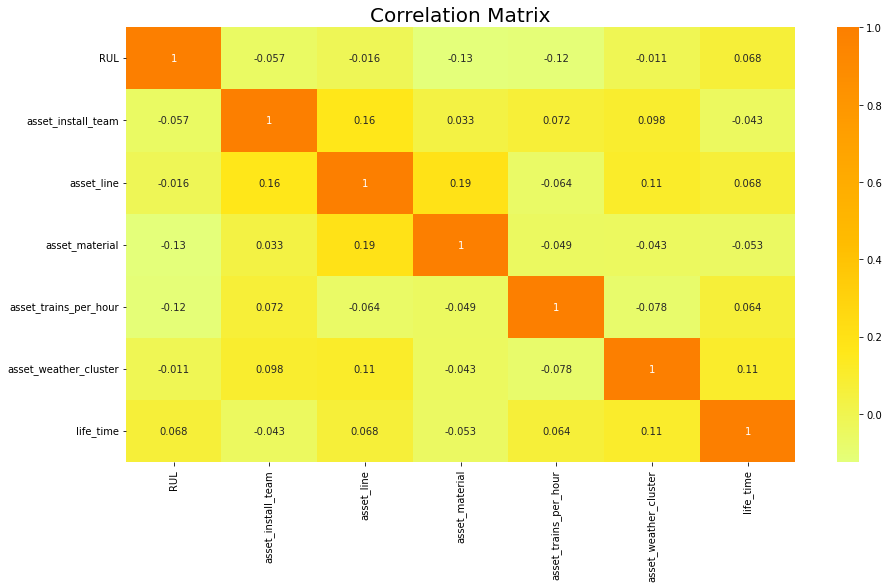

In [310]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(df_main.corr(), cmap = 'Wistia', annot = True)
plt.title('Correlation Matrix', fontsize = 20)
plt.show()

Seems like a week correlation

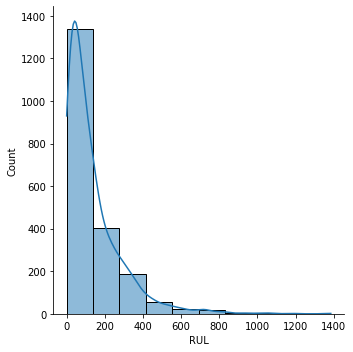

In [311]:
sns.displot(df_main['RUL'], bins=10, kde=True)

c:\users\manuelsousa\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='RUL'>

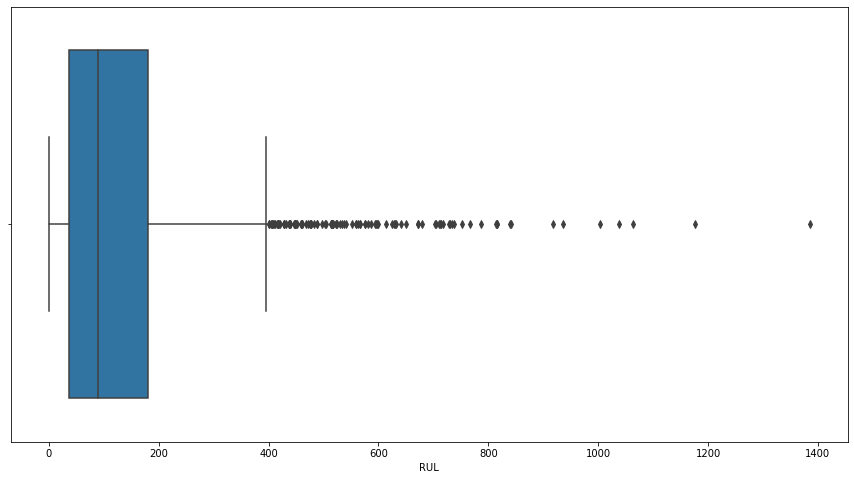

In [312]:
sns.boxplot(df_main['RUL'])

About continues variable RUL:
* No normal distribution (bell curve)
* Boxplot show a lot os outliers

In [313]:
# target matrix
y = df_main['RUL']

# feature matrix
X = df_main.loc[:, df_main.columns != 'RUL']

In [314]:
from sklearn.model_selection import train_test_split

# 80/20 training and testing splitting - Pareto principle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [315]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

In [324]:
# [4] pag.145 & [5]
# https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/
from sklearn.decomposition import PCA
 
# keep the first two principal components of the data
pca = PCA(n_components=4)
# fit PCA model to breast cancer data
pca.fit(X_scaled)
# transform data onto the first two principal components
X_pca_train = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca_train.shape)))
X_pca_test = pca.transform(X_test)

Original shape: (1625, 6)
Reduced shape: (1625, 4)


c:\users\manuelsousa\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [317]:
pca.explained_variance_ratio_

array([0.22026695, 0.19101112, 0.17904348, 0.15996304])

#### The following metrics are going to be used to evaluate the models performance: MAE, MSE and RMSE

In [318]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(real, pred):
    mae = mean_absolute_error(real, pred)
    mse = mean_squared_error(real, pred)
    rmse = mean_squared_error(real, pred, squared=False)
    return {'mae': mae, 'mse': mse, 'rmse': rmse}

## 4. Models training

#### Decision Tree

In [319]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

param = {'splitter':('best', 'random'), 
         'max_depth' : [1,2,3,4,5,10], 
         'min_samples_leaf' : [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35]}

dtr_model = RandomizedSearchCV(DecisionTreeRegressor(), param)
dtr_model.fit(X_pca, y_train)

RandomizedSearchCV(estimator=DecisionTreeRegressor(),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 10],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 10,
                                                             15, 20, 25, 30,
                                                             35],
                                        'splitter': ('best', 'random')})

In [320]:
dtr_model.best_estimator_

DecisionTreeRegressor(max_depth=3, splitter='random')

In [323]:
dtr_pred_train = dtr_model.predict(X_pca)
dtr_train_score = evaluate(y_train, dtr_pred_train)
print(dtr_train_score)

{'mae': 100.66815482375945, 'mse': 20894.552892694363, 'rmse': 144.54948250579923}


In [321]:
dtr_pred_test = dtr_model.predict(X_test)
dtr_test_score = evaluate(y_test, dtr_pred_test)
print(dtr_test_score)

c:\users\manuelsousa\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


ValueError: X has 6 features, but DecisionTreeRegressor is expecting 4 features as input.

In [ ]:
dtr_res = pd.DataFrame({
    'Model': ['Decision tree'], 
    'Test MAE': dtr_test_score['mae'], 
    'Test MSE': dtr_test_score['mse'] , 
    'Test RMSE': dtr_test_score['rmse'] 
})

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param = {'max_depth' : [1,2,3,4,5,10], 
         'min_samples_leaf' : [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 42, 44, 46, 48, 50, 52]}

rfr_model = RandomizedSearchCV(RandomForestRegressor(verbose=1, n_jobs=-1), param)
rfr_model.fit(X_pca, y_train)

In [ ]:
rfr_model.best_estimator_

In [ ]:
rfr_pred_test = rfr_model.predict(X_test)
rfr_test_score = evaluate(y_test, rfr_pred_test)
print(rfr_test_score)

In [ ]:
rfr_res = pd.DataFrame({
    'Model': ['Random Forest'],
    'Test MAE': rfr_test_score['mae'], 
    'Test MSE': rfr_test_score['mse'], 
    'Test RMSE': rfr_test_score['rmse'] 
})

r1 = dtr_res.append(rfr_res, ignore_index=True)

In [ ]:
r1

In [ ]:
tree.plot_tree(dtr_model) 